In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [17]:
csv_path = "../../results/domain_shift_linear.csv"
# csv_path = "../../results/domain_shift_finetune.csv"

In [18]:
df = pd.read_csv(csv_path, index_col=0)

In [19]:
df

,K400,UCF101,NTU60,SSv2,Gym99,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00,0
SeLaVi,24.05,51.18,15.74,4.51,20.23,0
RSPNet,42.84,76.63,33.47,12.52,32.16,0
VideoMoCo,30.99,66.27,51.58,19.54,41.57,0
Pretext-contrast,22.35,57.15,17.61,10.86,29.98,0
CTP,7.61,37.93,22.58,12.20,30.62,0
TCLR,19.84,63.26,33.45,10.84,33.04,0
GDT,38.61,75.73,38.21,11.87,34.15,0
AVID-CMA,43.49,78.14,53.93,16.12,45.12,0
Supervised,0.00,91.65,45.49,16.58,42.74,0


### Pre-processing

In [20]:
# remove column for `K400`

if "K400" in df.columns:
    df.drop(columns=["K400"], inplace=True)

In [21]:
# re-order datasets

def find_sub_element_in_list(x, L):
    """Finds an element in list L of which x is a substring"""
    for y in L:
        if x in y:
            return y

correct_order = ["UCF", "NTU", "Gym", "SS", "EPIC"]
reorder_colums = [find_sub_element_in_list(x, df.columns) for x in correct_order]

df = df[reorder_colums]

In [22]:
# re-order VSSL methods based on UCF performance

ref_dataset = find_sub_element_in_list("UCF", df.columns)
df.sort_values(ref_dataset, inplace=True)

In [23]:
df

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0
CTP,37.93,22.58,30.62,12.20,0
SeLaVi,51.18,15.74,20.23,4.51,0
Pretext-contrast,57.15,17.61,29.98,10.86,0
TCLR,63.26,33.45,33.04,10.84,0
VideoMoCo,66.27,51.58,41.57,19.54,0
GDT,75.73,38.21,34.15,11.87,0
RSPNet,76.63,33.47,32.16,12.52,0
AVID-CMA,78.14,53.93,45.12,16.12,0
Supervised,91.65,45.49,42.74,16.58,0


### Column-wise normalized

In [24]:
norm_df=(df-df.loc["None"])/(df.loc["Supervised"]-df.loc["None"])

In [25]:
def heatmap(
        df,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        **kwargs,
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel("Dataset")
    ax.set_ylabel("Method")
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

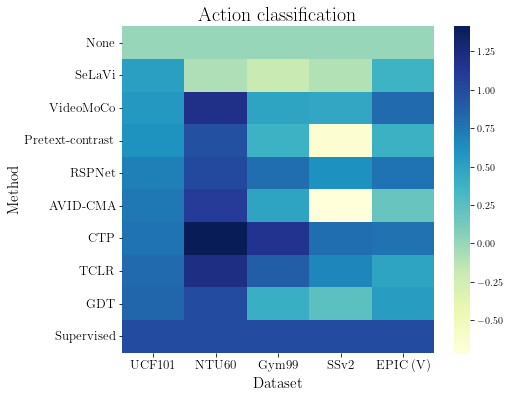

In [13]:
heatmap(norm_df)

### Normalizing between 0-1

In [26]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [27]:
annot = df.values
# annot = (df - df.T["None"]).values

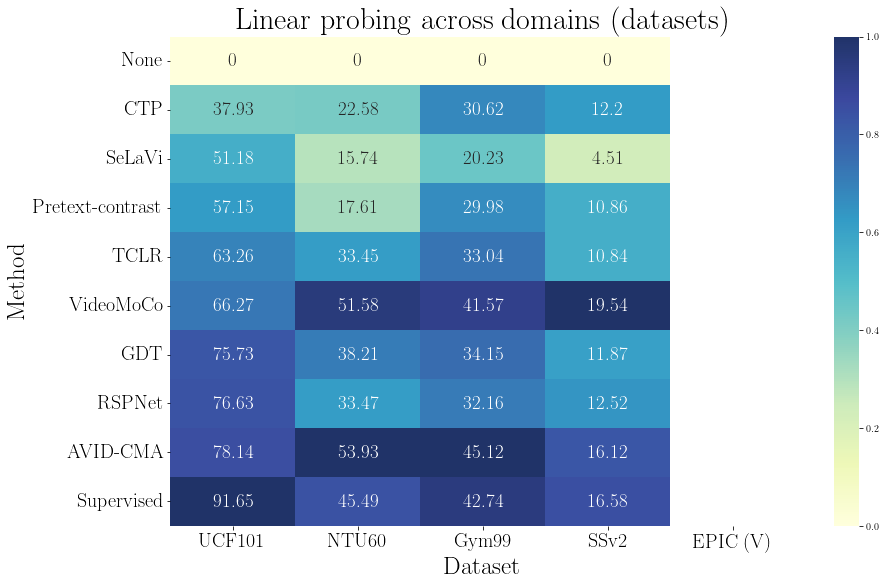

In [28]:
heatmap(
    normalized_df,
    figsize=(14, 9),
    title="Linear probing across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domain_shift_linear_v1.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=annot,
    fmt='g',
    annot_kws={"size": 19},
)

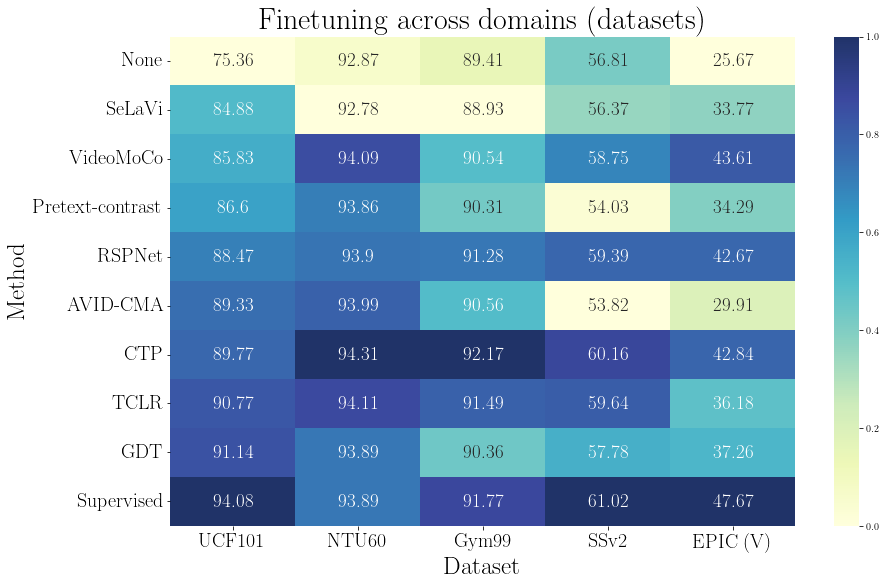

In [16]:
heatmap(
    normalized_df,
    figsize=(14, 9),
    title="Finetuning across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domain_shift_finetune_v1.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=annot,
    fmt='g',
    annot_kws={"size": 19},
)

### Relative improvement w.r.t. scratch

In [42]:
# normalized_df = (df - df.loc["None"]) / (df.loc["None"])
normalized_df = (df - df.loc["None"])
normalized_df /= normalized_df.max()

In [43]:
normalized_df

,UCF101,NTU,Something-something,FineGym,EPIC (Verb)
None,0.000000,0.000000,0.000000,0.000000,0.000000
SeLaVi,0.508547,-0.062500,-0.104513,-0.173913,0.368182
RSPNet,0.546474,0.444444,-0.726841,0.170290,0.479545
VideoMoCo,0.559295,0.847222,0.460808,0.409420,0.815455
Pretext-contrast,0.600427,0.687500,-0.660333,0.326087,0.391818
CTP,0.769765,1.000000,0.795724,1.000000,0.780455
TCLR,0.823184,0.861111,0.672209,0.753623,0.477727
GDT,0.842949,0.708333,0.230404,0.344203,0.526818
Supervised,1.000000,0.708333,1.000000,0.855072,1.000000


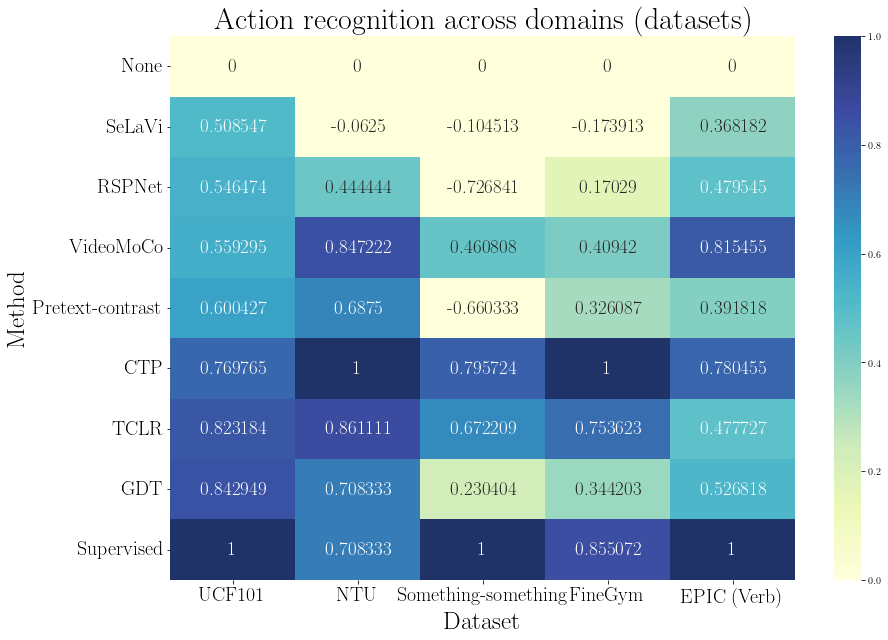

In [44]:
heatmap(
    normalized_df,
    figsize=(14, 10),
    title="Action recognition across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domains_expt_2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=normalized_df.values,
    fmt='g',
    vmin=0.0,
    vmax=1.0,
    annot_kws={"size": 19},
)

### Rank correlation

In [14]:
keys = df.columns

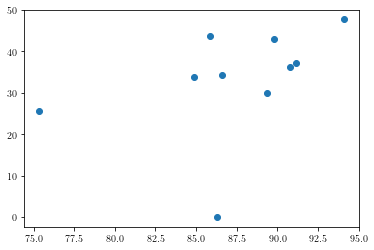

In [15]:
plt.scatter(df["UCF101"].values, df["EPIC (V)"].values)

[]

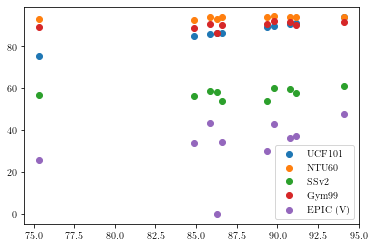

In [16]:
for key in keys:
    plt.scatter(df["UCF101"].values, df[key].values, label=key)
    
plt.legend()
plt.plot()